## PROYECTO INTEGRADOR

Jiram Cesar Villalpando Guerrero        A01793579

Josep Romagosa Llordén                  A01374637

José Francisco Muñoz Del Angel          A01794174

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import dask.dataframe as dd

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/MNA/Proyecto Final/Collab/data_source/'
csv_files = ['data0.csv','data1.csv','data2.csv','data3.csv','data4.csv','data5.csv','data6.csv','data7.csv','data8.csv','data9.csv','data10.csv']
dfs = [pd.read_csv(file_path + file) for file in csv_files]
data = pd.concat(dfs, ignore_index=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = data[['CourierCode', 'Parcel', 'ZipCodeFrom', 'ZipCodeTo', 'TransitAt', 'DeliveredAt']]

In [ ]:
df['ParcelDict'] = df['Parcel'].apply(json.loads)
df['Weight'] = df['ParcelDict'].apply(lambda x: x.get('Weight', 0))
df['Height'] = df['ParcelDict'].apply(lambda x: x.get('Height', 0))
df['Length'] = df['ParcelDict'].apply(lambda x: x.get('Length', 0))
df['Width'] = df['ParcelDict'].apply(lambda x: x.get('Width', 0))
df.drop(['Parcel', 'ParcelDict'], axis=1, inplace=True)

In [ ]:
df.head()

,CourierCode,ZipCodeFrom,ZipCodeTo,TransitAt,DeliveredAt,Weight,Height,Length,Width
0,STF,58116,87090,2021-12-21 18:28:00.0,2021-12-23 17:05:00.0,5,0,0,0
1,BMS,54730,2800,2024-04-08 14:11:00.0,2024-04-09 11:05:00.0,12,39,50,30
2,STF,37278,85490,2019-06-11 16:02:00.0,2019-06-15 09:25:00.0,3,15,55,30
3,99M,11500,62577,NaN,NaN,2,12,31,26
4,APM,54948,60094,2021-07-21 06:29:27.0,2021-07-21 10:03:46.0,5,1,10,1


In [ ]:
# Convertir columnas de fecha
df['TransitAt'] = pd.to_datetime(df['TransitAt'])
df['DeliveredAt'] = pd.to_datetime(df['DeliveredAt'])

In [ ]:
# Calculo de tiempo en transito
df['TransitTime'] = (df['DeliveredAt'] - df['TransitAt']).dt.total_seconds() / 3600

In [ ]:
# Transformación logaritmica de TransitTime para normalizar la distribucion
df['TransitTime_log'] = np.log1p(df['TransitTime'])

In [ ]:
# Añadir caracteristicas basadas en la fecha
df['TransitAt_year'] = df['TransitAt'].dt.year
df['TransitAt_month'] = df['TransitAt'].dt.month
df['TransitAt_weekday'] = df['TransitAt'].dt.weekday

In [ ]:
# Codificación de las variables categoricas
encoder = OneHotEncoder(sparse=False)
courier_status_encoded = encoder.fit_transform(df[['CourierCode']])
courier_status_features = encoder.get_feature_names_out(['CourierCode'])
courier_status_df = pd.DataFrame(courier_status_encoded, columns=courier_status_features)

month_weekday_encoded = encoder.fit_transform(df[['TransitAt_month', 'TransitAt_weekday']])
month_weekday_features = encoder.get_feature_names_out(['TransitAt_month', 'TransitAt_weekday'])
month_weekday_df = pd.DataFrame(month_weekday_encoded, columns=month_weekday_features)

# Concatenar las nuevas caracteristicas codificadas al dataframe original
df_encoded = pd.concat([df, courier_status_df, month_weekday_df], axis=1)

In [ ]:
# Eliminar columnas que ya no se necesitan
columns_to_drop = ['CourierCode', 'TransitAt', 'DeliveredAt', 'TransitAt_month', 'TransitAt_weekday']
df_encoded.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
cols_to_check = ['ZipCodeTo', 'Weight', 'Height', 'Length', 'Width']
df_encoded[cols_to_check] = df_encoded[cols_to_check].applymap(lambda x: pd.to_numeric(x, errors='coerce'))

# Eliminar filas con NaN en las columnas especificadas
df_encoded = df_encoded.dropna(subset=cols_to_check)

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1811730 entries, 0 to 1811731
Data columns (total 50 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ZipCodeFrom            int64  
 1   ZipCodeTo              float64
 2   Weight                 float64
 3   Height                 float64
 4   Length                 float64
 5   Width                  float64
 6   TransitTime            float64
 7   TransitTime_log        float64
 8   TransitAt_year         float64
 9   CourierCode_99M        float64
 10  CourierCode_APM        float64
 11  CourierCode_BMS        float64
 12  CourierCode_DHL        float64
 13  CourierCode_DHL_PAKKE  float64
 14  CourierCode_FDX        float64
 15  CourierCode_IVOY       float64
 16  CourierCode_MBE_DHL    float64
 17  CourierCode_MBE_FDX    float64
 18  CourierCode_MLE        float64
 19  CourierCode_MUB        float64
 20  CourierCode_PEX        float64
 21  CourierCode_PKD        float64
 22  CourierCode_RPK        

In [ ]:
# Imputar valores nan
imputer = SimpleImputer(strategy='mean')
df_encoded_filled = imputer.fit_transform(df_encoded)
df_encoded_filled = pd.DataFrame(df_encoded_filled, columns=df_encoded.columns)

In [ ]:
# Escalar las caracteristicas numericas
scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_encoded_filled)

In [ ]:
# Selección de caracteristicas mediante umbral de varianza
selector = VarianceThreshold(threshold=0.95)
df_reduced = selector.fit_transform(df_encoded_scaled)

In [ ]:
# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=2)  # Reduccion a 2 componentes principales
principal_components = pca.fit_transform(df_reduced)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

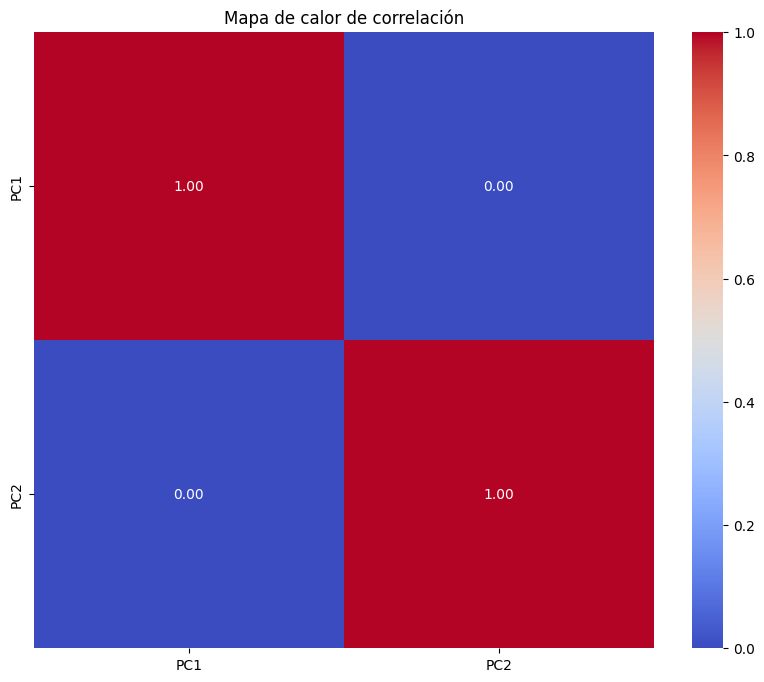

In [ ]:
corr_matrix = principal_df.corr()

# Crea un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Mapa de calor de correlación')
plt.show()

In [ ]:
loadings = pca.components_.T  # Transponer para alinear con las características originales
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=df_encoded.columns)

# Mostrar las cargas más significativas para cada componente principal
print("Cargas para PC1:")
print(loading_matrix['PC1'].sort_values(ascending=False))

print("\nCargas para PC2:")
print(loading_matrix['PC2'].sort_values(ascending=False))

Cargas para PC1:
Width                    0.472614
Length                   0.440744
Height                   0.432980
TransitTime_log          0.299270
Weight                   0.201181
TransitAt_weekday_nan    0.188749
TransitAt_month_nan      0.188749
TransitTime              0.154453
CourierCode_STF          0.133399
ZipCodeTo                0.130689
CourierCode_RPK          0.117010
CourierCode_FDX          0.078714
CourierCode_MBE_FDX      0.072085
CourierCode_SDX_MEX      0.056851
CourierCode_BMS          0.022218
CourierCode_PEX          0.021269
TransitAt_year           0.019592
CourierCode_UPS_INT      0.006392
CourierCode_IVOY         0.004593
CourierCode_DHL_PAKKE    0.003776
CourierCode_UPS          0.003616
CourierCode_MLE          0.002525
CourierCode_MUB          0.001066
CourierCode_UBER        -0.000248
CourierCode_MBE_DHL     -0.002447
CourierCode_STFRT       -0.002966
CourierCode_DHL         -0.003764
TransitAt_month_7.0     -0.005970
TransitAt_month_6.0     -0.0073

###Conclusiones
1. **Propósito y Objetivos:**

    Comenzamos con una meta clara: mejorar los tiempos de entrega en los servicios de courier. Este objetivo nos guió en la selección y creación de nuevas variables, como TransitTime, que calcula directamente el tiempo que tardan los paquetes en ser entregados.

2. **Análisis Inicial de los Datos:**

    Evaluamos los datos disponibles para comprender qué teníamos y cómo podíamos usarlo. Nos enfocamos en identificar las variables que necesitaban ser transformadas y las que requerían manipulación adicional, como el manejo de valores faltantes.
3. **Proceso de Preparación de Datos:**

    - **Limpieza:**

    Aseguramos que los datos estuvieran completos y libres de errores, lo cual es esencial para la precisión del análisis.

    - **Desarrollo de Nuevas Características:**

    Extrajimos información útil como el año, mes y día de la semana de envío para investigar su posible influencia en los tiempos de tránsito.
    - **Normalización y Estandarización:**

    Aplicamos técnicas para asegurar que todas las características se manejen en igualdad de condiciones, lo cual es crucial para el análisis y modelado posteriores.

    - **Reducción de la Complejidad:**
    Utilizamos PCA para simplificar los datos a sus componentes más significativos, eliminando así el ruido y las redundancias.

4. **Preparación para el Modelado:**

    Aunque aún no estamos en la etapa de modelado, la preparación adecuada de los datos garantiza que esta próxima fase sea más eficiente y los modelos más efectivos.

5. **Evaluación de la Preparación:**

    Es vital evaluar cómo la preparación de los datos impacta en la precisión y interpretación de los modelos, asegurando que los insights derivados sean aplicables y valiosos.

6. **Implementación:**

    Datos bien preparados facilitan la implementación de modelos en producción, reduciendo la necesidad de ajustes complejos y asegurando que los modelos se integren sin problemas en los procesos existentes.

####**Importancia del Proceso**
La fase de preparación de datos es crucial porque establece las bases para todas las fases subsecuentes del proyecto. Un buen manejo de los datos no solo facilita las etapas de modelado y evaluación, sino que también asegura que los resultados sean confiables y representativos del problema real. Además, documentar meticulosamente este proceso es esencial para la reproducibilidad y para proporcionar una base sólida para futuros proyectos y análisis.